In [1]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!cp "/content/drive/MyDrive/Colab Notebooks/kaggle_api_credentials/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                       title                                               size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------  -------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ruchi798/data-science-job-salaries                        Data Science Job Salaries                            7KB  2022-06-15 08:59:12           7909        267  1.0              
surajjha101/bigbasket-entire-product-list-28k-datapoints  BigBasket Entire Product List (~28K datapoints)      6MB  2022-06-22 12:51:18           2800        113  1.0              
victorsoeiro/netflix-tv-shows-and-movies                  Netflix TV Shows and Movies                          2MB  2022-05-15 00:01:23          17668        505  1.0              
sameepvani/nasa-nearest-earth-obje

In [4]:
! kaggle datasets download sionehoghen/facial-expression

 68% 41.0M/60.3M [00:01<00:00, 24.7MB/s]
100% 60.3M/60.3M [00:01<00:00, 35.3MB/s]


In [5]:
! unzip -q facial-expression.zip

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

tf.random.set_seed(4)

In [7]:
train_path = Path("/content/train")
test_path = Path("/content/test")

In [8]:
# getting image paths
train_image_paths = list(train_path.glob("*/*"))
train_image_paths = list(map(lambda x: str(x), train_image_paths))

print(train_image_paths[:10])

['/content/train/angry/Training_2778588.jpg', '/content/train/angry/Training_8813906.jpg', '/content/train/angry/Training_38018954.jpg', '/content/train/angry/Training_67027311.jpg', '/content/train/angry/Training_34928751.jpg', '/content/train/angry/Training_41568333.jpg', '/content/train/angry/Training_95669204.jpg', '/content/train/angry/Training_41898754.jpg', '/content/train/angry/Training_68732558.jpg', '/content/train/angry/Training_39536203.jpg']


In [9]:
# getting respective labels of images
def get_label(image_path):
  return image_path.split("/")[-2]

train_image_labels = list(map(lambda x: get_label(x), train_image_paths))

print(train_image_labels[:10])

['angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry', 'angry']


In [10]:
from sklearn.preprocessing import LabelEncoder

Le = LabelEncoder()
train_image_labels = Le.fit_transform(train_image_labels)

print(train_image_labels[:10])

[0 0 0 0 0 0 0 0 0 0]


In [11]:
train_image_labels = tf.keras.utils.to_categorical(train_image_labels)

print(train_image_labels[:10])

[[1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]]


In [12]:
from sklearn.model_selection import train_test_split

Train_paths, Val_paths, Train_labels, Val_labels = train_test_split(train_image_paths, train_image_labels, test_size=0.25)

In [13]:
Train_paths[:5], Val_paths[:5], Train_labels[:5], Val_labels[:5]

(['/content/train/fear/Training_79381162.jpg',
  '/content/train/angry/Training_26591418.jpg',
  '/content/train/surprise/Training_30949917.jpg',
  '/content/train/neutral/Training_68423650.jpg',
  '/content/train/sad/Training_15632432.jpg'],
 ['/content/train/angry/Training_52197003.jpg',
  '/content/train/happy/Training_96485203.jpg',
  '/content/train/angry/Training_66014049.jpg',
  '/content/train/happy/Training_76276874.jpg',
  '/content/train/sad/Training_79758901.jpg'],
 array([[0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]], dtype=float32),
 array([[1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0.]], dtype=float32))

In [14]:
# compute class weights
classTotals = Train_labels.sum(axis=0)
classWeight = classTotals.max()/classTotals

class_weight = {e: weight for e, weight in enumerate(classWeight)}
print(class_weight)

{0: 1.8216325, 1: 16.139881, 2: 1.753881, 3: 1.0, 4: 1.4574039, 5: 1.4849398, 6: 2.327468}


In [15]:
# load image data
def load(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels=3)
  return image, label

In [16]:
# define image & batch size
IMG_SIZE = 96
BATCH_SIZE = 32

# basic transformation
resize = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE, IMG_SIZE)
])

# data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(height_factor = (-0.1, -0.05)),
])


In [17]:
# function to create tf dataset object
AUTOTUNE = tf.data.experimental.AUTOTUNE

def get_dataset(paths, labels, train=True):
    image_paths = tf.convert_to_tensor(paths)
    labels = tf.convert_to_tensor(labels)

    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)

    dataset = tf.data.Dataset.zip((image_dataset, label_dataset))

    dataset = dataset.map(lambda image,label: load(image,label))
    dataset = dataset.map(lambda image,label: (resize(image),label), num_parallel_calls=AUTOTUNE)
    dataset = dataset.shuffle(1000)
    dataset = dataset.batch(BATCH_SIZE)

    if train:
      dataset = dataset.map(lambda image,label: (data_augmentation(image), label), num_parallel_calls=AUTOTUNE)

    dataset = dataset.repeat()
    return dataset

In [18]:
# creating train dataset object & verifying it
%time train_dataset = get_dataset(Train_paths, Train_labels)

image, label = next(iter(train_dataset))
print(image.shape)
print(label.shape)

CPU times: user 1.08 s, sys: 21 ms, total: 1.1 s
Wall time: 1.83 s
(32, 96, 96, 3)
(32, 7)


neutral


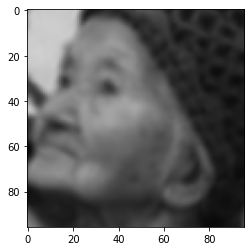

In [19]:
# view a sample training image
print(Le.inverse_transform(np.argmax(label, axis=1))[0])
plt.imshow((image[0].numpy()/255).reshape(96,96,3))

In [20]:
# creating val dataset object & verifying it
%time val_dataset = get_dataset(Val_paths, Val_labels, train=False)

image, label = next(iter(val_dataset))
print(image.shape)
print(label.shape)

CPU times: user 28.7 ms, sys: 1.9 ms, total: 30.6 ms
Wall time: 50.1 ms
(32, 96, 96, 3)
(32, 7)


angry


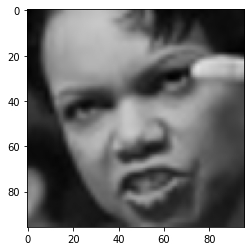

In [21]:
# view a sample val image
print(Le.inverse_transform(np.argmax(label, axis=1))[0])
plt.imshow((image[0].numpy()/255).reshape(96,96,3))

#### Building EfficientNet Model

In [22]:
from tensorflow.keras.applications import EfficientNetB2

backbone = EfficientNetB2(
    input_shape = (96,96,3),
    include_top = False,
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(7, activation="softmax"),
])

model.summary()

31801344/31790344 [==============================] - 1s 0us/step
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 7,882,249
Non

In [23]:
# compiling model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
)

In [24]:
# train model
history = model.fit(
    train_dataset,
    steps_per_epoch = len(Train_paths)//BATCH_SIZE,
    epochs = 12,
    # callbacks = [checkpoint, early_stop],
    validation_data = val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight = class_weight,
)

Epoch 1/12
672/672 [==============================] - 124s 143ms/step - loss: 2.7832 - accuracy: 0.4030 - precision: 0.6459 - recall: 0.1947 - val_loss: 1.6379 - val_accuracy: 0.3640 - val_precision: 0.5109 - val_recall: 0.1833
Epoch 2/12
672/672 [==============================] - 96s 140ms/step - loss: 2.3722 - accuracy: 0.4923 - precision: 0.6784 - recall: 0.2918 - val_loss: 1.4926 - val_accuracy: 0.4654 - val_precision: 0.6042 - val_recall: 0.3305
Epoch 3/12
672/672 [==============================] - 93s 138ms/step - loss: 2.2258 - accuracy: 0.5275 - precision: 0.7009 - recall: 0.3343 - val_loss: 1.3596 - val_accuracy: 0.4880 - val_precision: 0.5977 - val_recall: 0.3545
Epoch 4/12
672/672 [==============================] - 94s 139ms/step - loss: 2.1195 - accuracy: 0.5440 - precision: 0.7114 - recall: 0.3603 - val_loss: 1.4070 - val_accuracy: 0.4805 - val_precision: 0.5932 - val_recall: 0.3271
Epoch 5/12
672/672 [==============================] - 94s 140ms/step - loss: 2.0382 - accur

In [33]:
# turn off the backbone
model.layers[0].trainable = False

In [26]:
# defining callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint("best_weights.h5", verbose=1, save_best_only=True, save_weights_only=True)
early_stop = tf.keras.callbacks.EarlyStopping(patience=4)

In [27]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb2 (Functional)  (None, 3, 3, 1408)       7768569   
                                                                 
 global_average_pooling2d (G  (None, 1408)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1408)              0         
                                                                 
 dense (Dense)               (None, 128)               180352    
                                                                 
 dense_1 (Dense)             (None, 7)                 903       
                                                                 
Total params: 7,949,824
Trainable params: 181,255
Non-trainable params: 7,768,569
______________________________________

In [28]:
# train the phase 2 of model
history = model.fit(
    train_dataset,
    steps_per_epoch = len(Train_paths)//BATCH_SIZE,
    epochs = 8,
    callbacks = [checkpoint, early_stop],
    validation_data = val_dataset,
    validation_steps = len(Val_paths)//BATCH_SIZE,
    class_weight = class_weight,
)

Epoch 1/8
672/672 [==============================] - ETA: 0s - loss: 1.6620 - accuracy: 0.6311 - precision: 0.7483 - recall: 0.5010
Epoch 1: val_loss improved from inf to 1.05514, saving model to best_weights.h5
672/672 [==============================] - 94s 139ms/step - loss: 1.6620 - accuracy: 0.6311 - precision: 0.7483 - recall: 0.5010 - val_loss: 1.0551 - val_accuracy: 0.6091 - val_precision: 0.7002 - val_recall: 0.5112
Epoch 2/8
672/672 [==============================] - ETA: 0s - loss: 1.6099 - accuracy: 0.6401 - precision: 0.7532 - recall: 0.5144
Epoch 2: val_loss improved from 1.05514 to 1.02879, saving model to best_weights.h5
672/672 [==============================] - 93s 138ms/step - loss: 1.6099 - accuracy: 0.6401 - precision: 0.7532 - recall: 0.5144 - val_loss: 1.0288 - val_accuracy: 0.6211 - val_precision: 0.7174 - val_recall: 0.5230
Epoch 3/8
672/672 [==============================] - ETA: 0s - loss: 1.5901 - accuracy: 0.6447 - precision: 0.7520 - recall: 0.5260
Epoch 3:

Testing Phase

In [49]:
backbone = EfficientNetB2(
    input_shape = (96,96,3),
    include_top = False,
)

model = tf.keras.Sequential([
    backbone,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(7, activation="softmax"),
])

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy', tf.keras.metrics.Precision(name='precision'), tf.keras.metrics.Recall(name='recall')],
)

In [50]:
model.load_weights("best_weights.h5")

In [51]:
# Create a Dataset Object for 'Testing' Set just the way we did for Training and Validation
test_image_paths = list(test_path.glob("*/*"))
test_image_paths = list(map(lambda x: str(x), test_image_paths))
test_labels = list(map(lambda x: get_label(x), test_image_paths))

test_labels = Le.transform(test_labels)
test_labels = tf.keras.utils.to_categorical(test_labels)

test_image_paths = tf.convert_to_tensor(test_image_paths)
test_labels = tf.convert_to_tensor(test_labels)

def decode_image(image, label):
  image = tf.io.read_file(image)
  image = tf.io.decode_jpeg(image, channels=3)
  image = tf.image.resize(image, [96,96], method="bilinear")
  return image, label

test_dataset = (
    tf.data.Dataset
    .from_tensor_slices((test_image_paths, test_labels))
    .map(decode_image)
    .batch(BATCH_SIZE)
)

In [52]:
# verify test dataset object
image, label = next(iter(test_dataset))

print(image.shape)
print(label.shape)

(32, 96, 96, 3)
(32, 7)


angry


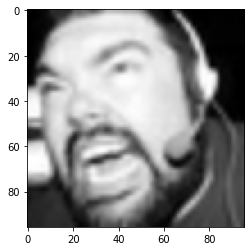

In [53]:
# view a sample validation image
print(Le.inverse_transform(np.argmax(label, axis=1))[0])
plt.imshow((image[0].numpy()/255).reshape(96,96,3))

In [54]:
# evaluating the loaded model
loss, acc, prec, rec = model.evaluate(test_dataset)

print("Testing Accuracy: ", acc)
print("Testing Precision: ", prec)
print("Testing Recall: ", rec)

225/225 [==============================] - 10s 30ms/step - loss: 1.0290 - accuracy: 0.6330 - precision: 0.7080 - recall: 0.5539
Testing Accuracy:  0.6330454349517822
Testing Precision:  0.7079772353172302
Testing Recall:  0.5539147257804871


In [55]:
# save model
model.save("DetectFacialExpressionModel.h5")

In [58]:
# save label encoder
import pickle
def save_object(obj, name):
  pickle_obj = open(f"{name}.pck","wb")
  pickle.dump(obj, pickle_obj)
  pickle_obj.close()

In [59]:
save_object(Le, "LabelEncoder")